In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Get Data

### Get Tables from DB into DataFrame

In [2]:
conn = sqlite3.connect("books.db")
cursor = conn.cursor()

In [3]:
# Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print table names
for table in tables:
    print(table[0])

books


In [4]:
query = cursor.execute("SELECT * FROM books;")
cols = [column[0] for column in query.description]
genres_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

In [5]:
print(genres_df.head)

<bound method NDFrame.head of                                                  authors  average_rating  \
0                 [{'author_id': '3041852', 'role': ''}]            4.13   
1                   [{'author_id': '19158', 'role': ''}]            4.22   
2                    [{'author_id': '5411', 'role': ''}]            4.43   
3      [{'author_id': '589328', 'role': ''}, {'author...            4.29   
4                  [{'author_id': '169159', 'role': ''}]            3.57   
...                                                  ...             ...   
99995               [{'author_id': '31468', 'role': ''}]            3.54   
99996  [{'author_id': '1319428', 'role': ''}, {'autho...            3.77   
99997             [{'author_id': '4874418', 'role': ''}]            4.27   
99998  [{'author_id': '166573', 'role': ''}, {'author...            3.69   
99999  [{'author_id': '6509355', 'role': ''}, {'autho...            3.69   

        book_id                                        de

In [6]:
conn.close()

# EDA

### For genres

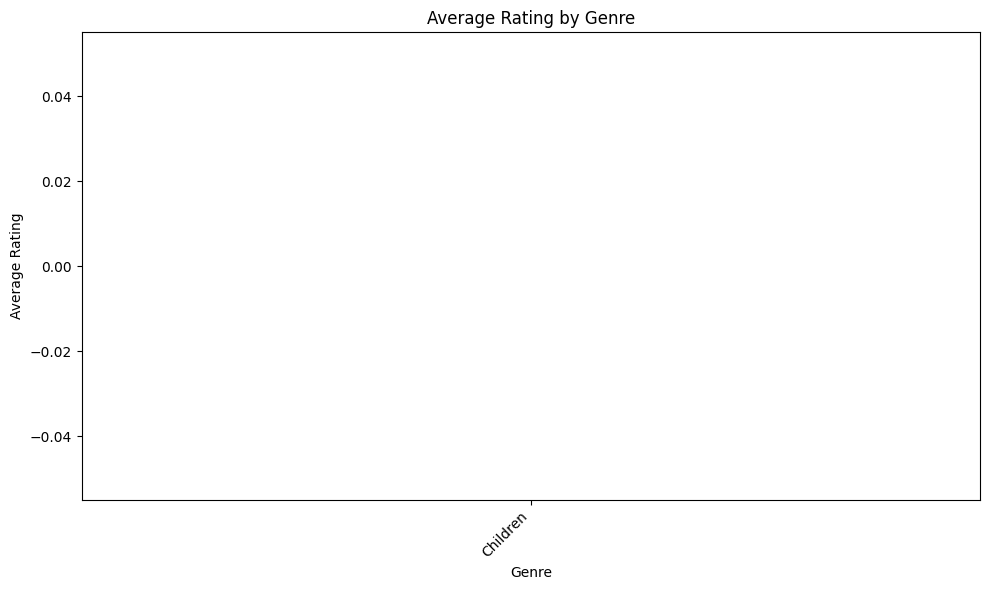

In [7]:
# average rating across the genres

# get genre columns 
genre_cols = [col for col in genres_df.columns if col.startswith("is_")]

# convert true/false to boolean
for col in genre_cols:
    genres_df[col] = genres_df[col].map({'TRUE': True, 'FALSE': False})

# compute average rating per genre
avg_ratings = {
    col.replace("is_", "").replace("_", " ").title(): genres_df[genres_df[col] == True]['average_rating'].mean()
    for col in genre_cols
}

# convert to Series and sort
avg_ratings_series = pd.Series(avg_ratings).sort_values(ascending=False)

# plot
plt.figure(figsize=(10, 6))
plt.bar(avg_ratings_series.index, avg_ratings_series.values, color='mediumseagreen', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.tight_layout()

# add value labels above bars
for i, v in enumerate(avg_ratings_series.values):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', va='bottom')

plt.show()


In [11]:
print(genres_df.columns)

Index(['authors', 'average_rating', 'book_id', 'description', 'genres',
       'is_children', 'is_comics_graphics', 'is_fantasy_paranormal',
       'is_history_biography', 'is_mystery_thriller_crime', 'is_poetry',
       'is_romance', 'is_young_adult', 'num_pages', 'ratings_count', 'series',
       'similar_books', 'title', 'title_without_series'],
      dtype='object')


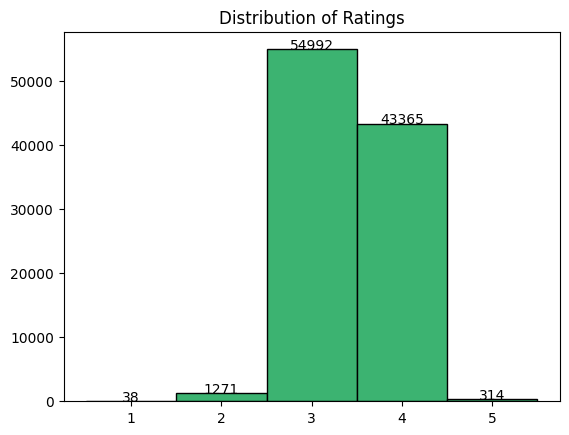

In [8]:
# histogram of ratings across all genres 
 
plt.title("Distribution of Ratings")
 
counts, bins, patches = plt.hist(genres_df['average_rating'], bins=range(1, 7), align='left', edgecolor='black', color='mediumseagreen')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 0.5, int(count), ha='center')

In [9]:
# get most popular books for each genre from highest ratings_count

most_popular_books = {}

for col in genre_cols:
    genre_name = col.replace("is_", "").replace("_", " ").title()
    genre_books = genres_df[genres_df[col] == True]

    if not genre_books.empty:
        top_book = genre_books.loc[genre_books['ratings_count'].idxmax()]
        most_popular_books[genre_name] = {
            'title': top_book['title_without_series'],
            'ratings_count': top_book['ratings_count']
        }


In [10]:
# convert to df
mpb_df = pd.DataFrame.from_dict(most_popular_books, orient='index')
mpb_df.reset_index(inplace=True)
mpb_df.rename(columns={'index': 'genre'}, inplace=True)

# plot
plt.figure(figsize=(10, 6))
plt.bar(mpb_df.title, mpb_df.ratings_count, color='mediumseagreen', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.title("Highest Rating Count of Book in Each Genre")
plt.xlabel("Book")
plt.ylabel("Rating Count")
plt.tight_layout()

# add value labels above bars
for i, v in enumerate(mpb_df.ratings_count):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', va='bottom')

plt.show()


AttributeError: 'DataFrame' object has no attribute 'title'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# plot
plt.figure(figsize=(10, 6))
plt.bar(mpb_df.genre, mpb_df.ratings_count, color='mediumseagreen', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.title("Highest Rating Count of Book in Each Genre")
plt.xlabel("Book")
plt.ylabel("Rating Count")
plt.tight_layout()

# add value labels above bars
for i, v in enumerate(mpb_df.ratings_count):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', va='bottom')

plt.show()
